In [1]:
# pip install pickle5 pandas biopython matplotlib drawSvg bs4
import io, pickle5, time, urllib, Bio.PDB, sys, pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem 
from rdkit.Chem.Draw import IPythonConsole  
from rdkit.Geometry.rdGeometry import Point3D 
from rdkit.Chem import PandasTools 
PandasTools.RenderImagesInAllDataFrames(images=True)  
#pd.set_option('display.max_columns', None) 
#pd.set_option('display.max_rows', None) 
from IPython.core.display import display, HTML, SVG
display(HTML("<style>.container { width:100% !important; }</style>")) 

df = pd.read_pickle('df_cov_sanitized.pkl')
#df['adduct_bin']  = df.apply(lambda x: x.adduct_pdb.ToBinary(), axis=1)  
#df['binder_bin']  = df.apply(lambda x: x.binder_pdb.ToBinary(), axis=1)  
#df.drop(columns=['adduct_pdb','binder_pdb']).to_csv('df_cov_sanitized.csv')

RDKit WARNING: [19:18:00] Enabling RDKit 2019.09.1 jupyter extensions


In [2]:
from rdkit.Chem import Draw  
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D 

Amino_Acids = {'ALA': 'C[C@@H](C(=O)O)N', 'ARG': 'C(C[C@@H](C(=O)O)N)CNC(=[NH2+])N', 'ASN': 'C([C@@H](C(=O)O)N)C(=O)N', 'ASP': 'C([C@@H](C(=O)O)N)C(=O)O', 'CYS': 'C([C@@H](C(=O)O)N)S', 'GLN': 'C(CC(=O)N)[C@@H](C(=O)O)N', 'GLU': 'C(CC(=O)O)[C@@H](C(=O)O)N', 'GLY': 'C(C(=O)O)N', 'HIS': 'c1c([nH+]c[nH]1)C[C@@H](C(=O)O)N', 'ILE': 'CC[C@H](C)[C@@H](C(=O)O)N', 'LEU': 'CC(C)C[C@@H](C(=O)O)N', 'LYS': 'C(CC[NH3+])C[C@@H](C(=O)O)N', 'MET': 'CSCC[C@@H](C(=O)O)N', 'PHE': 'c1ccc(cc1)C[C@@H](C(=O)O)N', 'PRO': 'C1C[C@H](NC1)C(=O)O', 'SER': 'C([C@@H](C(=O)O)N)O', 'THR': 'C[C@H]([C@@H](C(=O)O)N)O', 'TRP': 'c1ccc2c(c1)c(c[nH]2)C[C@@H](C(=O)O)N', 'TYR': 'c1cc(ccc1C[C@@H](C(=O)O)N)O', 'VAL': 'CC(C)[C@@H](C(=O)O)N'}

In [3]:
from PIL import Image, ImageOps, ImageChops

def get_proper_size(m):
    i = 1000
    old_size = None
    while True: 
        im = Chem.Draw.MolToImage(m, size=(i, i))
        bg = Image.new(im.mode, im.size, color='white')
        diff = ImageChops.difference(im, bg)
        bbox = diff.getbbox()
        if bbox:
            new_size = im.crop(bbox).size
            if max(new_size)<i-200:
                return new_size
            if new_size == old_size:
                return new_size
            else:
                old_size=new_size
        else:
            raise
        i += 200

s = '[H][C@@]([C@]([H])(CO)O[C@@]([H])(O[C@]([C@]([H])(CO)O[C@](OC[C@](O[C@]([H])(O[C@@]([C@@]([H])(CO)O[C@@]([H])(O[C@@]([H])([C@@]([H])1O)O[C@@]([H])(CO)[C@]([H])(O[C@]([H])([C@]([H])2O)O[C@@]([H])(CO[C@@]([H])([C@@]([H])3O)O[C@@]([H])(CO)[C@]([H])(O[C@@]([H])([C@@]([H])4O)O[C@@]([H])(CO)[C@]([H])(O)[C@]4(O)[H])[C@]3(O)[H])[C@@]([H])(O)[C@@]2(O)[H])[C@]1(O)[H])[C@]([H])5O)([H])[C@@]5(O)[H])[C@]([H])6O)([H])[C@@]([H])(O)[C@@]6(O)[H])([H])[C@@]([H])7O)([H])[C@]7(O)[H])[C@@]([H])8O)(O)[C@]8(O)[H]'
get_proper_size(Chem.MolFromSmiles(s))

(821, 457)

In [4]:
Amino_Acids_SVGs = {}
for aa_name, aa_smiles in Amino_Acids.items(): 
    aa_mol = Chem.MolFromSmiles(aa_smiles)
    size   = get_proper_size(aa_mol)
    if not aa_mol.GetNumConformers():
        rdDepictor.Compute2DCoords(aa_mol) 
    drawer = rdMolDraw2D.MolDraw2DSVG(*size)
    drawer.DrawMolecule(aa_mol)
    drawer.FinishDrawing()
    aa_svg = drawer.GetDrawingText().replace('xmlns=','this_is_garbage=')
    Amino_Acids_SVGs[aa_name] = aa_svg

In [5]:
collector = set()
for _, row in df.iterrows(): 
    binder_pdb = row['binder_pdb']  
    size   = get_proper_size(binder_pdb)
    if not binder_pdb.GetNumConformers():
        rdDepictor.Compute2DCoords(binder_pdb) 
    drawer = rdMolDraw2D.MolDraw2DSVG(*size)
    drawer.DrawMolecule(binder_pdb)
    drawer.FinishDrawing()
    binder_svg = drawer.GetDrawingText().replace('xmlns=','this_is_garbage=')   
    
    aa_name    = row['aa_name'] 
    aa_svg     = Amino_Acids_SVGs[aa_name]
     
    adduct_pdb = row['adduct_pdb']  
    size   = get_proper_size(adduct_pdb)
    if not adduct_pdb.GetNumConformers():
        rdDepictor.Compute2DCoords(adduct_pdb) 
    drawer = rdMolDraw2D.MolDraw2DSVG(*size)
    drawer.DrawMolecule(adduct_pdb,confId=0)
    drawer.FinishDrawing()
    adduct_svg = drawer.GetDrawingText().replace('xmlns=','this_is_garbage=')  
    break

In [6]:
import xml.etree.ElementTree as ET
binder_root = ET.fromstring(binder_svg)
aa_root     = ET.fromstring(aa_svg)
adduct_root = ET.fromstring(adduct_svg)

def get_shape(root):
    _,_,width,height=root.attrib['viewBox'].split()
    return int(width), int(height) 

binder_width, binder_height = get_shape(binder_root)
aa_width    ,     aa_height = get_shape(    aa_root)
adduct_width, adduct_height = get_shape(adduct_root)

max_height = max([binder_height, aa_height, adduct_height,10])
full_width = binder_width + 10 + aa_width + 40 + adduct_width 

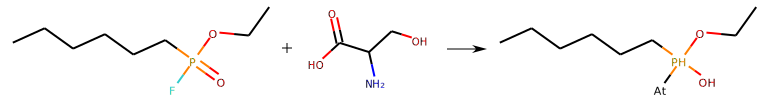

In [7]:
svg = ET.Element('svg', attrib={'viewBox':f'0 0 {full_width} {max_height}'})

aa_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'aa'})
aa_root = ET.fromstring(aa_svg)
for child in aa_root:
    if child.tag.endswith('rect'): 
        continue
        child.set('style', 'fill:black;stroke:1') 
    aa_symbol.append(child)

binder_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'binder'})
binder_root = ET.fromstring(binder_svg)
for child in binder_root:
    if child.tag.endswith('rect'): 
        continue
        child.set('style', 'fill:black;stroke:1') 
    binder_symbol.append(child)

adduct_symbol = ET.SubElement(svg, 'symbol', attrib={'id':'adduct'})
adduct_root = ET.fromstring(adduct_svg)
for child in adduct_root:
    if child.tag.endswith('rect'): 
        continue
        child.set('style', 'fill:black;stroke:1')  
    adduct_symbol.append(child)

plus_symbol   = ET.SubElement(svg, 'symbol', attrib={'id':'plus'})
_ = ET.SubElement( plus_symbol, 'line', attrib={'x1':'0', 'x2':'10', 'y1': '5', 'y2': '5',   'stroke':'rgb(0, 0, 0)', 'stroke-width':'1'})
_ = ET.SubElement( plus_symbol, 'line', attrib={'x1':'5', 'x2': '5', 'y1': '0', 'y2':'10',   'stroke':'rgb(0, 0, 0)', 'stroke-width':'1'})

arrow_symbol  = ET.SubElement(svg, 'symbol', attrib={'id':'arrow'})
_ = ET.SubElement(arrow_symbol, 'line', attrib={'x1':'0', 'x2': '35', 'y1':'5', 'y2': '5',   'stroke':'rgb(0, 0, 0)', 'stroke-width':'1'})
_ = ET.SubElement(arrow_symbol, 'path', attrib={'d':'M 25 1 L 40 5 L 25 9 C 30 5 30 5 25 1', 'stroke-miterlimit':'1', 'stroke-width':'1'})

y_center = max([binder_height, aa_height, adduct_height, 10])/2
_ = ET.SubElement(svg, 'use', attrib={'href':'#binder', 'x':'0'                , 'y':str(y_center-binder_height/2)})
_ = ET.SubElement(svg, 'use', attrib={'href':  '#plus', 'x':str(binder_width)  , 'y':str(y_center-5)})
_ = ET.SubElement(svg, 'use', attrib={'href':    '#aa', 'x':str(binder_width+10) , 'y':str(y_center-aa_height/2)})
_ = ET.SubElement(svg, 'use', attrib={'href':'#adduct', 'x':str(binder_width+10+aa_width+40) , 'y':str(y_center-adduct_height/2)})
_ = ET.SubElement(svg, 'use', attrib={'href': '#arrow', 'x':str(binder_width+10+aa_width) , 'y':str(y_center-4)})
 
SVG(ET.tostring(svg))